# Assignment 2: Deep learning for texture synthesis - Part 2
Aurélie Bugeau 
_Credits: Ryan Webster and Julien Rabin (Ensicaen)_

The goal of this assignment is to perform texture synthesis with deep learning. There are three parts to this assignement: 
 1. Have a closer look at a deep classification network (VGG-19) [1]
 2. Implement and test the texture synthesis with a generative network method of [2]
 
 [1] K. Simonyan, A. Zisserman. "Very Deep Convolutional Networks for Large-Scale Image Recognition", arXiv:1409.1556, 2014  
 [2] Ulyanov, Lebedev, Vedaldi, Lempitsky. "Texture Networks: Feed-forward Synthesis of Textures and Stylized Images", ICML, 2016  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from my_utils import *

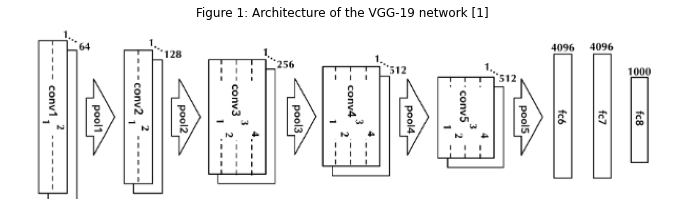

In [2]:
#Plot Figure 1 with caption
plotImage(Image.open("./VGG-19.png"),"Figure 1: Architecture of the VGG-19 network [1]", figsize_=(12,8))

The network is defined is file *Models_VGG/vgg.py*. Let us load it.

In [3]:
# Load modules
import torch
import torchvision
import torch.nn as nn
from VGG_Models.vgg import get_vgg_net
import numpy

In [4]:
vgg_net = get_vgg_net()
for param in vgg_net.parameters():
    param.requires_grad = True
print(vgg_net)

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

#### <font color='red'> Question 1 </font>
Open an image and run a forward pass of the VGG-19 network over it. Visualize and justify the feature sizes 

(256, 256)


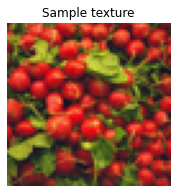

CUDA ON
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 4, 4])


In [5]:
# Open an image 
sample = Image.open('Images/raddish.jpg')
print(sample.size)
sample = sample.resize((64,64))  #You may uncomment this line
plotImage(sample,"Sample texture", figsize_=(3,3))

# Convert it to a tensor
sample = prep(sample).unsqueeze(0)
sample.require_grad = False


if torch.cuda.is_available():
    print("CUDA ON")
    sample = sample.cuda()

sample_feats = vgg_net(sample) #similar to vgg_net.forward(tens)
sample_feats = [out.detach() for out in sample_feats]#.detach to avoid tracking the gradients of this variable
# Visualize sizes of network RELU activations 
for feat in sample_feats:
     print(feat.size())


In [2], a CNN generates a texture image from a noisy vector $z$ sampled from a certain distribution $Z$.

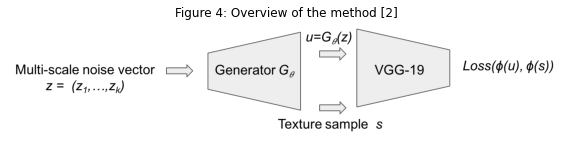

In [6]:
plotImage(Image.open("./Ulyanov16.png"), "Figure 4: Overview of the method [2]", (10,10))


The loss is computed from the Gram matrices of the VGG pre-trained features. More precisely, the loss The loss compares Gram matrices from the groundtruth texture with the ones of the infered image. The complete learning then optimizes:
$$ \min_\theta \mathbb{E}_{z\sim Z} \sum_l\| \Phi_l(G_\theta(z))-\Phi_l(s) \|_2^2, $$

where the Gram matrices $\Phi_l$  of an image $u$ at layer $l$ is given by:
$$\Phi_l(u) = \frac{1}{H_lW_lD_l} \phi_l(u)\phi_l^T(u)$$
with $\phi_l$ the feature after activation at layer $l$.

#### <font color='red'> Question 2 </font> 
Explain this formula and implement it

In [7]:
#Phi = X*transpose(X)
class GramMatrix(nn.Module):
    def forward(self, feat):
        b, d, h, w = feat.size() #batch size, channel, height, width
        # !! COMPLETE to obtain the GRAM matrix of size dxd
        feat_resize = feat.view(b*d, h*w)
        Phi = torch.matmul(feat_resize,feat_resize.t())/(h*w*d)
        return Phi
gram_matrix = GramMatrix()
gram_sample_feats = [gram_matrix(feat) for feat in sample_feats]

We will use network architectures hiven in folder TextureNetwork/

In [8]:
from TextureNetwork.models import Pyramid2D

# create generator network
gen = Pyramid2D(ch_in=3, ch_step=8)
if torch.cuda.is_available():
    gen = gen.cuda()

Let us now train this network in order to generate images of size H $\times $ W $\times $ D

#### <font color='red'> Question 3 </font>
Complete the following code in order to train the network to learn to generate a texture similar to the sample

We encourage you to use gradient normalisation during training by applying function *Normalize_gradients.apply* defined in file *my_utils.py* on the VGG features of the generated noise vector. It means that during gradient descent we only consider the direction of the gradient and not its magnitude.  (e.g. Normalize_gradients.apply(feat))

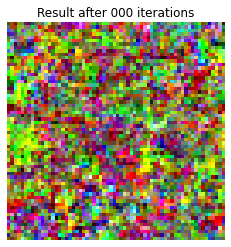

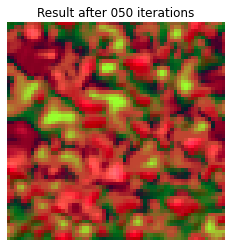

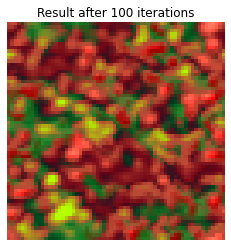

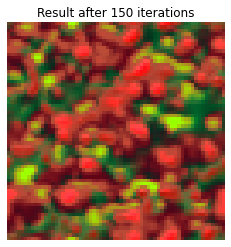

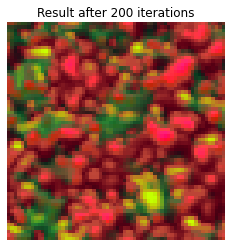

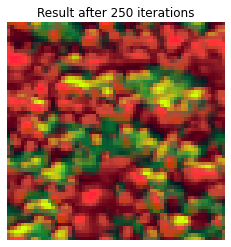

---> lr adjusted to 0.08000000000000002


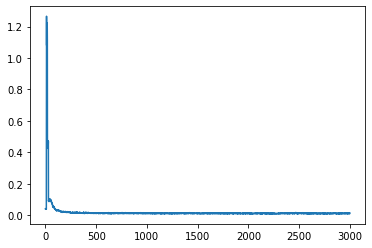

In [9]:
#Save folder
out_folder = "out"
import os
if os.path.exists(out_folder)==False:
    os.mkdir(out_folder)

out_folder_model = "out_model"
if os.path.exists(out_folder_model)==False:
    os.mkdir(out_folder_model)

#output dimension
H = 64
W = 64
D = 3
#Learning parameters
N_optim_iter = 300 #number of iteration
save_every = 50 #how often are images saved
save_params = save_every
lambda_loss = 1e5
batch_size = 10
myloss = nn.L1Loss()

#Optimization parameters
learning_rate = 0.1
lr_adjust = 300
lr_decay_coef = 0.8
min_lr = 0.001
optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)

#Scales of the noise vector
szH = [H/1,H/2,H/4,H/8,H/16,H/32]
szW = [W/1,W/2,W/4,W/8,W/16,W/32]

#run training
for n_iter in range(N_optim_iter):
    optimizer.zero_grad()
    
    # element by element to allow the use of large training sizes
    for i in range(batch_size):
        #generate multiscale noise
        if torch.cuda.is_available():
            zk = [torch.rand((1,D,int(szh),int(szw)), requires_grad=True, device='cuda') for szh,szw in zip(szH, szW)]
        else:
            zk = [torch.rand((1,D,int(szh),int(szw)), requires_grad=True) for szh,szw in zip(szH, szW)]

        g_z = gen(zk)[0,:,:,:].unsqueeze(0)
        if torch.cuda.is_available():
            g_z = g_z.cuda()


        # compute VGG features of image G(z) to compare them with those of the sample 
        g_z_feats = vgg_net(g_z) # !! COMPLETE
        gram_gz_feats = [gram_matrix(Normalize_gradients.apply(feat)) for feat in g_z_feats]
        # compute loss
        # We encourage you to use gradient normalisation (see above text)
        #COMPLETE
        loss = 0
        for j in range(len(gram_gz_feats)):
            loss += myloss(gram_gz_feats[j],gram_sample_feats[j])

        loss.backward()
        loss_iter = loss.item()
        del  loss,  zk, g_z_feats


    if n_iter%save_every==0:
        usave = postp(g_z.cpu().detach().squeeze())
        plotImage(usave, 'Result after {:03d} iterations'.format(n_iter)) 
        usave.save(out_folder + 'iteration_{:03d}.jpg'.format(n_iter), "JPEG")
    del g_z

    #Update learning rate
    optimizer.step()
    if optimizer.param_groups[0]['lr'] > min_lr:
        if n_iter%lr_adjust == (lr_adjust-1):
            optimizer.param_groups[0]['lr'] = lr_decay_coef * optimizer.param_groups[0]['lr']
            print('---> lr adjusted to '+str(optimizer.param_groups[0]['lr']))

# save the network
if os.path.exists(out_folder_model+ '/trained_model.py'):
    os.remove(out_folder_model+ '/trained_model.py')
if os.path.exists(out_folder_model+ '/params.pytorch'):
    os.remove(out_folder_model+ '/params.pytorch')
torch.save(gen, out_folder_model+ '/trained_model.py')
torch.save(gen.state_dict(), out_folder_model+ '/params.pytorch')

#### <font color='red'> Question 4 </font>
Now that the network is trained, apply it to generate new texture images from a random noise image. Comment the results. 

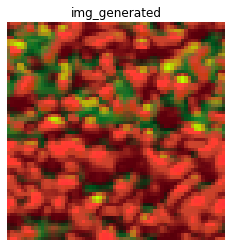

In [10]:
#To load a pretrained network from file
generator  = Pyramid2D(ch_in=3, ch_step=8)
generator.load_state_dict(torch.load('./' + out_folder_model+ '/params.pytorch'))

with torch.no_grad():
    generator.eval()
for param in generator.parameters():
    param.requires_grad = False

#COMPLETE
#Il faut lancer le model, déjà entrainé à produire des images de poivrons, sur une image de bruit.
# Il peut créer des images de poivrons sans se baser sur des images de poivrons.
zk = [torch.rand((1,D,int(szh),int(szw)), requires_grad=True) for szh,szw in zip(szH, szW)]

g_z = generator(zk)
usave = postp(g_z.cpu().detach().squeeze())
plotImage(usave, 'img_generated'.format(n_iter))
usave.save(out_folder + 'gn{:03d}.jpg'.format(n_iter), "JPEG")
 


#### <font color='red'> Question 5 </font>
Experiment with different losses, images, layers, analyse your results, visualise the loss. 
